# Lookalike Model

This notebook outlines the process of building a lookalike model that takes user's information as input and recommends 3 similar customers based on their profile and transaction history. The model will use both customer and product information, and assign a similarity score to each recommended customer.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import Required Libraries  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline  
from scipy.spatial.distance import cosine, jaccard

In [2]:
customers = pd.read_csv('../datasets/Customers.csv')
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [3]:
products = pd.read_csv('../datasets/Products.csv')
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [4]:
transactions = pd.read_csv('../datasets/Transactions.csv')
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [5]:
customer_profile_features = customers[['CustomerID', 'Region']]
customer_profile_features.head()

,CustomerID,Region
0,C0001,South America
1,C0002,Asia
2,C0003,South America
3,C0004,South America
4,C0005,Asia


In [6]:
# customer_profile_features= pd.get_dummies(customer_profile_features, columns=['Region'])
# customer_profile_features.head()

In [7]:
# map each customer's Region to its corresponding Hemisphere
def map_to_hemisphere(region):
    if region in ['North America', 'South America']:
        return 'West'
    elif region in ['Europe', 'Asia']:
        return 'East'
    else:
        return region

# apply the mapping to create a new column 'Hemisphere'
customers['Hemisphere'] = customers['Region'].apply(map_to_hemisphere)

# one hot encode the new 'Hemisphere' column
hemisphere_encoded = pd.get_dummies(customers[['CustomerID', 'Hemisphere']], 
                                    columns=['Hemisphere'], 
                                    prefix='Hemisphere', 
                                    dtype=int)

# merge the encoded features with customer_data on 'CustomerID'
customer_profile_features = pd.merge(customer_profile_features, hemisphere_encoded, on='CustomerID', how='left')

# display the updated customer_data
customer_profile_features.head()

,CustomerID,Region,Hemisphere_East,Hemisphere_West
0,C0001,South America,0,1
1,C0002,Asia,1,0
2,C0003,South America,0,1
3,C0004,South America,0,1
4,C0005,Asia,1,0


In [8]:
user_product_matrix = transactions.pivot_table(index='CustomerID', columns='ProductID', values='Quantity')
user_product_matrix.head()

ProductID,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010,...,P091,P092,P093,P094,P095,P096,P097,P098,P099,P100
CustomerID,,,,,,,,,,,,,,,,,,,,,
C0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
C0002,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
C0003,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C0004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
C0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_product_matrix_scaled = scaler.fit_transform(user_product_matrix)
user_product_matrix_scaled

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 1.12089708,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [21]:
user_product_matrix_scaled_df = pd.DataFrame(
    user_product_matrix_scaled, 
    index=user_product_matrix.index, 
    columns=user_product_matrix.columns
)
merged_df = pd.merge(customer_profile_features, user_product_matrix_scaled_df, on='CustomerID', how='inner')
merged_df.drop(columns=['Region'], inplace=True)
merged_df.fillna(0, inplace=True)
merged_df.head()

,CustomerID,Hemisphere_East,Hemisphere_West,P001,P002,P003,P004,P005,P006,P007,...,P091,P092,P093,P094,P095,P096,P097,P098,P099,P100
0,C0001,0,1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,-0.267261,0.000000,0.0,0.0,0.0
1,C0002,1,0,0.0,0.000000,0.0,1.212678,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,-0.693375,0.000000,0.000000,0.0,0.0,0.0
2,C0003,0,1,0.0,1.120897,0.0,0.000000,0.0,0.219971,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,C0004,0,1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.196116,0.0,0.0,0.0
4,C0005,1,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [22]:
merged_df.set_index('CustomerID', inplace=True)

In [23]:
from sklearn.decomposition import PCA

# apply PCA
pca = PCA().fit(merged_df.fillna(0))

In [24]:
# calculate cumulative sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

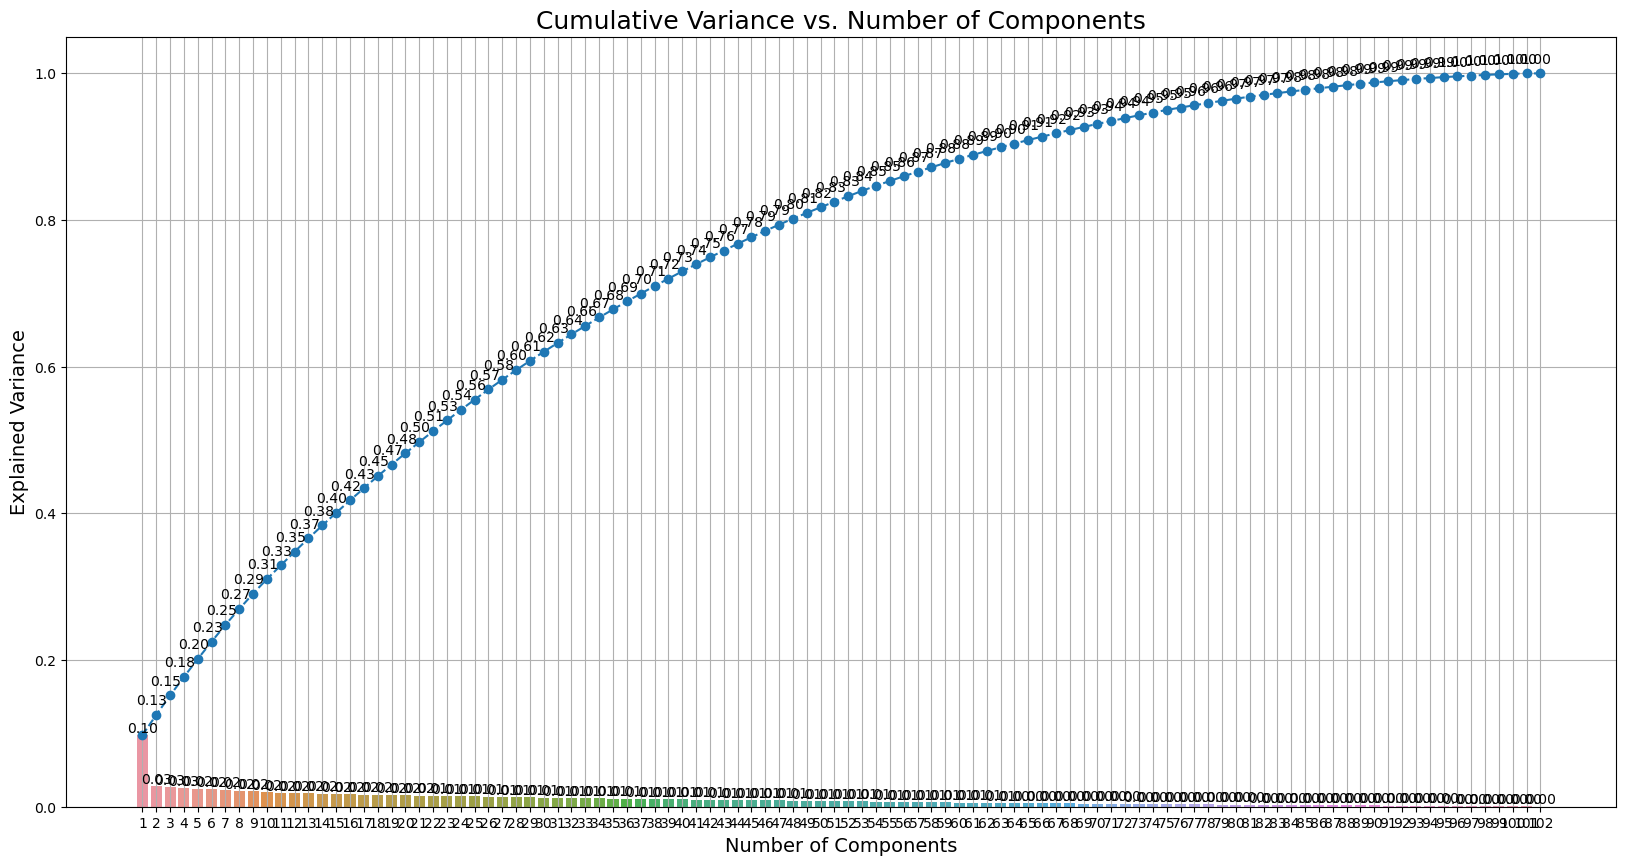

In [25]:
# plot the cumulative explained variance against the number of components
plt.figure(figsize=(20,10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance)+1)),
                      y=explained_variance_ratio)

lineplot = plt.plot(range(0, len(cumulative_explained_variance)),
                    cumulative_explained_variance,
                    marker='o', linestyle='--')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)


# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [26]:
# creating a pca object with 5 components
pca = PCA(n_components=62)

customer_data_pca = pca.fit_transform(merged_df)

# create a new dataframe from PCA dataframe
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# adding CustomerID to new PCA dataframe
customer_data_pca.index = merged_df.index

In [27]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62
CustomerID,,,,,,,,,,,,,,,,,,,,,
C0001,0.686571,0.026323,-0.318293,0.513218,-0.285163,-0.014375,-0.131324,-0.293678,0.260439,-0.262711,...,0.023058,-0.092859,-0.139460,0.064889,-0.007251,-0.045644,-0.087272,-0.042589,-0.125752,-0.083177
C0002,-0.730763,-0.075955,0.129377,-0.026329,-0.016654,0.030612,-0.084204,-0.069305,0.129258,0.034500,...,0.068936,-0.044819,-0.192713,0.458242,0.276190,0.120038,-0.240788,-0.191806,-0.129791,-0.058658
C0003,0.689155,-0.064451,-0.087430,0.277383,0.121408,-0.166072,-0.017428,-0.037465,0.129896,0.297239,...,-0.044088,0.001659,0.051056,-0.212029,0.113125,-0.018253,0.032725,0.075974,-0.071585,0.004362
C0004,0.721797,0.269630,0.441948,-0.456807,0.125983,0.512043,-0.942372,0.059702,-0.623266,0.282383,...,0.183269,0.027214,-0.349617,-0.007568,0.637270,0.047720,0.382616,-0.063943,-0.050410,-0.133961
C0005,-0.723780,-0.078544,0.074230,0.052045,0.072875,-0.108850,-0.099332,0.012165,-0.004606,-0.048580,...,0.011618,-0.010676,0.066913,-0.033453,-0.011044,0.009800,-0.049826,-0.049848,0.129687,0.100990


In [36]:
def get_top_lookalikes(customer_id, customer_data, top_n=3):
    target_vector = customer_data.loc[customer_id].values
    similarities = {}
    
    for other_id in customer_data.index:
        if other_id == customer_id:
            continue
        vector = customer_data.loc[other_id].values
        sim = 1 - cosine(target_vector, vector)
        similarities[other_id] = sim
        
    top_lookalikes = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_lookalikes

top3_lookalikes = get_top_lookalikes('C0001', customer_data_pca, top_n=3)
print("Top 3 lookalikes for C0001:")
for cust, score in top3_lookalikes:
    print(f"{cust} with similarity {score:.2f}")


Top 3 lookalikes for C0001:
C0083 with similarity 0.64
C0165 with similarity 0.57
C0130 with similarity 0.50


In [32]:
# Define the list of customer IDs to query
customer_ids = ['C0001', 'C0083', 'C0165', 'C0130']

# Filter transactions for the selected customers
filtered_transactions = transactions[transactions['CustomerID'].isin(customer_ids)]

# Merge transactions with customers to get the region info
merged_data = pd.merge(filtered_transactions, customers[['CustomerID', 'Region']], 
                       on='CustomerID', how='left')

# Merge with products to get product details (e.g., ProductName)
merged_data = pd.merge(merged_data, products[['ProductID', 'ProductName']], 
                       on='ProductID', how='left')

# Group by CustomerID and Region, and list unique purchased products
result = merged_data.groupby(['CustomerID', 'Region'])['ProductName'] \
                      .apply(lambda x: list(x.unique())).reset_index()

print(result)

  CustomerID         Region                                        ProductName
0      C0001  South America  [SoundWave Cookbook, HomeSense Wall Art, Sound...
1      C0083  South America  [HomeSense T-Shirt, SoundWave Cookbook, BookWo...
2      C0130  South America                  [ComfortLiving Bluetooth Speaker]
3      C0165  South America  [SoundWave Cookbook, SoundWave Novel, TechPro ...


In [33]:
result

,CustomerID,Region,ProductName
0,C0001,South America,"[SoundWave Cookbook, HomeSense Wall Art, Sound..."
1,C0083,South America,"[HomeSense T-Shirt, SoundWave Cookbook, BookWo..."
2,C0130,South America,[ComfortLiving Bluetooth Speaker]
3,C0165,South America,"[SoundWave Cookbook, SoundWave Novel, TechPro ..."


In [34]:
result['ProductName']

0    [SoundWave Cookbook, HomeSense Wall Art, Sound...
1    [HomeSense T-Shirt, SoundWave Cookbook, BookWo...
2                    [ComfortLiving Bluetooth Speaker]
3    [SoundWave Cookbook, SoundWave Novel, TechPro ...
Name: ProductName, dtype: object

In [35]:
pd.set_option('display.max_colwidth', None)
result

,CustomerID,Region,ProductName
0,C0001,South America,"[SoundWave Cookbook, HomeSense Wall Art, SoundWave Headphones, ActiveWear Smartwatch, TechPro Headphones]"
1,C0083,South America,"[HomeSense T-Shirt, SoundWave Cookbook, BookWorld Jacket]"
2,C0130,South America,[ComfortLiving Bluetooth Speaker]
3,C0165,South America,"[SoundWave Cookbook, SoundWave Novel, TechPro Novel, SoundWave Jacket, TechPro Headphones, ActiveWear Running Shoes]"
